# T2 Zeiten für LMO Probe

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np

In [ ]:
from func import ticks_handle
import file_organizer as fo
an_options = dict(xycoords='data', textcoords='offset points',
                        fontsize=10,arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=.2"))

## T2 aus einfachem Echo

day one, meas == F

In [ ]:
# import file list and select files
path = 'data_day_one'
file_list = fo.load_file_list(path)
selection = (fo.select_files(file_list,'meas','F'))

# load data to pd.dataFrame
data = fo.load_files(selection)
data = fo.df_combine(data)
data["time"] = data["time"] * 1000

# data.info()
del(data['iout'])
del(data['qout'])

# extract parameter (label, tau)
label = list(data.columns)
label.remove('time')
tau = np.array([meas.tau for meas in selection])*1000 

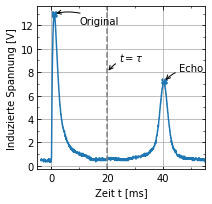

In [ ]:
idx = 8
signal = data[label[idx]]
time = data['time']
pidx = find_peaks(signal, height=2, distance=40, width=10)[0]

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(time, signal, label='Signal')
ax.scatter(time[pidx], signal[pidx], marker='X')
ax.annotate('Original', (time[pidx[0]], signal[pidx[0]]), 
                xytext=(25,-10),**an_options, ha='left')
ax.annotate('Echo', (time[pidx[1]], signal[pidx[1]]), 
                xytext=(15,10),**an_options, ha='left')

ax.set_xlim(-5,55)
ylim = ax.get_ylim()
ax.vlines(tau[idx],*ylim, color='gray', ls='--')
ax.annotate('$t=\\tau$', (tau[idx], 8), 
                xytext=(12,11),**an_options, ha='left')
ax.set_ylim(*ylim)

ax.grid()
ax.set_xlabel('Zeit t [ms]')
ax.set_ylabel('Induzierte Spannung [V]')
ticks_handle(ax, which='both')
fig.savefig('IMAGES/lmo_t2_echo.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from lmfit import Model
def fit_t2(t, y, log=False):
    def t2func(t, M0, T2):#
        return M0*np.exp(-t/T2)#+const

    model = Model(t2func, nan_policy='omit')
    res = model.fit(y, t=t, M0=1, T2=20)
    if log: print(res.fit_report())
    return res

In [ ]:
# peak-finding
peaks = [find_peaks(data[l], height=2, distance=40, width=10)[0] for l in label]
idx = [peaks[0][0]] + [p[1] for p in peaks[1:]]
time = data['time'][idx]
value = np.array([data.loc[i, l] for i,l in zip(idx, label)])

# use fit-function from another file
result = fit_t2(time[1:], value[1:], log=False)
t2 = result.params['T2']

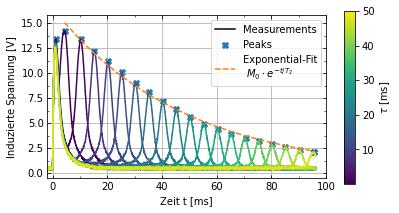

In [ ]:
ran = slice(0, 20,1) # reduce lines

fig,ax=plt.subplots(figsize=(5,3))

from func import get_norm_cm
colormap, m, n = get_norm_cm('viridis', min(tau), max(tau))
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb1 = mpl.colorbar.ColorbarBase(ax=ax2, cmap=m,norm=n)
ax2.set_ylabel('$\\tau$ [ms]')

for l, t, in zip(label[ran], tau[ran]):
    data.plot(x='time', y=l, ax=ax, label='', color=colormap(t))
ax.plot([],[], label='Measurements', color='black')
ax.scatter(time, value, marker='X',label='Peaks')
ax.plot(time[1:], result.best_fit, '--', 
    label=f'Exponential-Fit\n $M_0\cdot e^{{-t/T_2}}$', color='tab:orange')

ax.set_xlabel('Zeit t [ms]')
ax.set_ylabel('Induzierte Spannung [V]')
ax.set_xlim(-2,100)
ax.legend()
ax.grid()
ticks_handle(ax, which='both')
fig.savefig('IMAGES/lmo_t2_echo.png', dpi=300,bbox_inches='tight')
plt.show()

## T2 aus Multipulse

In [ ]:
path = 'data_day_one'

file_list = fo.load_file_list(path)

meas1 = fo.select_files(file_list,'filename','scope_78.csv')[0]
data1 = fo.load_meas(meas1)
data1.name = 'Carr-Pucell'

meas2 = fo.select_files(file_list,'filename','scope_80.csv')[0]
data2 = fo.load_meas(meas2)
data2.name = 'Meiboom-Gill'

for d in [data1, data2]:
    del(d['iout'])
    del(d['qout'])
    d['time'] = d['time'] * 1000

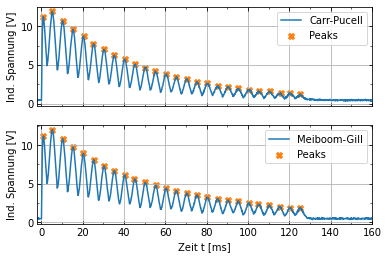

In [ ]:
peaks = {d.name:find_peaks(d['signal'], distance=40, height=1)[0] for d in [data1, data2]}

fig,axs = plt.subplots(2,1,figsize=(6,4), sharex=True)
for d,ax in zip([data1,data2], axs):
    p = peaks[d.name]
    d.plot(x='time', y='signal', ax=ax,label=f'{d.name}')
    ax.scatter(d['time'][p],d['signal'][p], marker='X',color='tab:orange', label='Peaks')
    ax.set_xlim(-2,160)
    ax.set_xlabel('Zeit t [ms]')
    ax.set_ylabel('Ind. Spannung [V]')
    ax.legend()
    ax.grid()
    ticks_handle(ax, which='both')
fig.savefig('IMAGES/lmo_t2_multi.png', dpi=300,bbox_inches='tight')


In [ ]:
names = [d.name for d in [data1, data2]]
times  = [np.array([d.loc[p, 'time']   for p in peaks[d.name]]) for d in [data1,data2]]
values = [np.array([d.loc[p, 'signal'] for p in peaks[d.name]]) for d in [data1, data2]]
results = [fit_t2(t=time[1:], y=value[1:], log=False) for time, value in zip(times, values)]

## Comparison

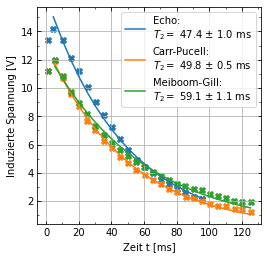

In [ ]:
fig,ax = plt.subplots(sharex=True, figsize=(4,4))
for t,v,res,l in zip([time]+times, [value]+values,[result] + results, ['Echo']+names):
    ax.scatter(t, v, marker='X')
    t2string = f'{res.params["T2"].value:5.1f} $\\pm$ {res.params["T2"].stderr:3.1f} ms'
    ax.plot(t[1:], res.best_fit, label=f'{l}:\n$T_2=${t2string}')
ax.set_xlabel('Zeit t [ms]')
ax.set_ylabel('Induzierte Spannung [V]')
ax.legend()
ax.grid()
ticks_handle(ax, which='both')
fig.savefig('IMAGES/lmo_t2_result.png', dpi=300, bbox_inches='tight')

In [ ]:
for name, res in zip(['Echo']+names, [result]+results):
    print(name)
    print(res.fit_report())
    print()

Echo
[[Model]]
    Model(t2func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 20
    # variables        = 2
    chi-square         = 1.57293816
    reduced chi-square = 0.08738545
    Akaike info crit   = -46.8557392
    Bayesian info crit = -44.8642747
[[Variables]]
    M0:  16.5071432 +/- 0.22778795 (1.38%) (init = 1)
    T2:  47.3516247 +/- 0.96389816 (2.04%) (init = 20)
[[Correlations]] (unreported correlations are < 0.100)
    C(M0, T2) = -0.772

Carr-Pucell
[[Model]]
    Model(t2func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 25
    # variables        = 2
    chi-square         = 0.35096567
    reduced chi-square = 0.01525938
    Akaike info crit   = -102.648567
    Bayesian info crit = -100.210816
[[Variables]]
    M0:  13.0237995 +/- 0.09102304 (0.70%) (init = 1)
    T2:  49.8283329 +/- 0.49359545 (0.99%) (init = 20)
[[Correlations]] (unreported correlation

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c333ff75-d5d2-432c-b928-cf45631da0c3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>